In [1]:
import torch
import nn

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model1 = nn.Model('resnet18', 200)
# model2 = nn.Model('dresnet18', 200)
model3 = nn.Model('psaresnet18', 200)
# model4 = nn.Model('psaresnet18', 200)
# model5 = nn.Model('psdresnet18', 200)
# model6 = nn.Model('psddresnet18', 200)
# model1.count_parameters()
# model1.model = model1.model
# print()
# model2.count_parameters()
# model2.model = model2.model

128 128
Success to initialize psaresnet18 model
Total trainable parameters: 1,703,528


In [3]:
model3.model = model3.model.cuda()
i = torch.zeros(16,3, 64, 64).cuda()

In [4]:
model3.model(i).shape

torch.Size([16, 200])

In [4]:
def count_parameters(model, verbose=1):
    total_params = 0
    params = {}
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            print('???')
            continue
        param_count = parameter.numel()
        total_params += param_count
        if verbose:
            if verbose==1:
                block = name.split('.')[0]
                if block not in params:
                    params[block] = param_count
                else:
                    params[block] += param_count
            elif verbose==2:
                params[name] = param_count
    
    print(f"Total trainable parameters: {total_params:,}")

    print("Layer-wise parameter counts:")
    for name, count in params.items():
        print(f"{name}: {count:,}")
    
    return total_params

In [5]:
from nn.modules import Conv, DConv, PSA, PSD

In [6]:
psa = PSA(256, 256)
count_parameters(psa, verbose=1)

Total trainable parameters: 249,728
Layer-wise parameter counts:
cv1: 66,048
cv2: 66,048
attn: 51,328
ffn: 66,304


249728

In [8]:
psd = PSD(256, 256)
count_parameters(psd, verbose=1)

Total trainable parameters: 259,416
Layer-wise parameter counts:
cv1: 66,048
cv2: 66,048
attn: 61,016
ffn: 66,304


259416

In [12]:
(259416-249728 )/249728

0.038794208098411075

In [9]:
conv = Conv(512, 512)
count_parameters(conv, verbose=2)

Total trainable parameters: 2,360,320
Layer-wise parameter counts:
conv.weight: 2,359,296
bn.weight: 512
bn.bias: 512


2360320

In [10]:
dconv = DConv(512, 512, 3)
count_parameters(dconv, verbose=2)

Total trainable parameters: 1,784,848
Layer-wise parameter counts:
cv1.weight: 393,216
cv1.bias: 768
conv.offset_mask.weight: 995,328
conv.offset_mask.bias: 1,296
cv2.weight: 393,216
bn.weight: 512
bn.bias: 512


1784848

In [11]:
conv

Conv(
  (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): SiLU()
)

In [12]:
dconv

DConv(
  (conv): DCNv4(
    (offset_mask_dw): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
    (offset_mask): Linear(in_features=1024, out_features=1728, bias=True)
    (value_proj): Linear(in_features=512, out_features=1024, bias=True)
    (output_proj): Linear(in_features=1024, out_features=512, bias=False)
  )
  (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): SiLU()
)

In [13]:
count_parameters(dconv.conv)

Total trainable parameters: 2,831,040
Layer-wise parameter counts:
offset_mask_dw: 10,240
offset_mask: 1,771,200
value_proj: 525,312
output_proj: 524,288


2831040

In [36]:
count_parameters(dconv.conv.offset_mask)

Total trainable parameters: 443,232
Layer-wise parameter counts:
weight: 442,368
bias: 864


443232

In [3]:
import torch
import time

In [4]:
p = torch.nn.Linear(256, 256, bias=False).cuda()
c = torch.nn.Conv2d(256, 256, kernel_size=1, bias=False).cuda()

In [17]:
i = torch.zeros(16, 256, 320, 320).cuda()
st = time.time()
i = i.permute(0, 2, 3, 1).view(16, 320*320, 256)
# st = time.time()
px = p(i)
et = time.time()
print(et-st)

0.0002951622009277344


In [18]:
i = torch.zeros(16, 256, 320, 320).cuda()
i = i.view(16, 320, 320, 256).permute(0, 3, 1, 2)
st = time.time()
cx = c(i)
et = time.time()
print(et-st)

0.0002608299255371094


In [4]:
from DCNv4 import DCNv4
from nn.modules.common import *
import torch
import torch.nn as nn
import time

In [6]:
class DConv(nn.Module):
    def __init__(self, c1, c2, k=3, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        assert k==3
        self.conv = DCNv4(c1, c2, k, s, autopad(k, p, d), dw_kernel_size=k, without_pointwise=False, output_bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else act if isinstance(act, nn.Module) else None

    def forward(self, x):
        b, c, h, w = x.shape
        st = time.time()
        x = x.permute(0, 2, 3, 1).view(b, h*w, -1).contiguous()
        rt1 = time.time()
        x = self.conv(x)
        rt2 = time.time()
        x = x.view(b, h, w, -1).permute(0, 3, 1, 2)
        rt3 = time.time()
        print(rt1-st)
        print(rt2-rt1)
        print(rt3-rt2)
        x = self.bn(x)
        return self.act(x) if self.act else x

In [9]:
dconv = DConv(512, 512).cuda()

In [10]:
i = torch.zeros(16, 512, 16, 16).cuda()

In [11]:
dconv(i)

0.0007355213165283203
0.013594627380371094
1.1682510375976562e-05


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
# 다 conv하고 추가로 dconv 얇게 하나 해보자

In [13]:
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
a=torch.arange(125).reshape(5,5,5)
a[0]

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])

In [26]:
a.transpose(-2, -1)[0]

tensor([[ 0,  5, 10, 15, 20],
        [ 1,  6, 11, 16, 21],
        [ 2,  7, 12, 17, 22],
        [ 3,  8, 13, 18, 23],
        [ 4,  9, 14, 19, 24]])

In [27]:
a.permute(0, 2, 1)[0]

tensor([[ 0,  5, 10, 15, 20],
        [ 1,  6, 11, 16, 21],
        [ 2,  7, 12, 17, 22],
        [ 3,  8, 13, 18, 23],
        [ 4,  9, 14, 19, 24]])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import nn, data
import torch.nn.functional as F

In [8]:
model = nn.Model(path='trained_models/resnet18_1')
test_loader, _ = data.get_dataloader('tiny-imagenet',
                                     split='test',
                                     imgsz=64,
                                     batch_size=1)
test_images = []
test_labels = []
for i, (img, label) in enumerate(test_loader):
    test_images += [img]
    test_labels += [label]
    if i==3:
        break

Success to load model from trained_models/resnet18_1
model_name:resnet18
params:1453800
epoch:66
recall:0.45343338815789475
test_recall:0.4544
test_loss:2.3552433227668725

Total trainable parameters: 1,453,800
dataset/tiny-imagenet-200 already exists
Success to load tiny-imagenet test dataset


In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1)
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()


In [30]:
target_layer = model.model.layer4[-1]
grad_cam =GradCAM(model.model, target_layer)

img = test_images[0]
heatmap = grad_cam(img.cuda())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
class UnNormalize():
    def __init__(self, mean=0.5, std=0.5):
        self.mean = np.array(mean).astype(np.float32)
        self.std = np.array(std).astype(np.float32)

    def __call__(self, img):
        return img * self.std + self.mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


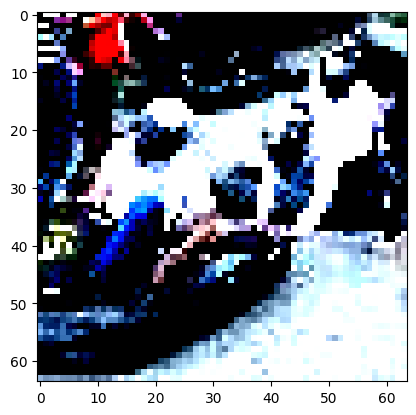

In [34]:
plt.imshow(img[0].permute(1,2,0))

In [35]:
import cv2

In [40]:
heatmap.shape

(8, 8)

In [41]:
heatmap2 = cv2.resize(heatmap, [64, 64])

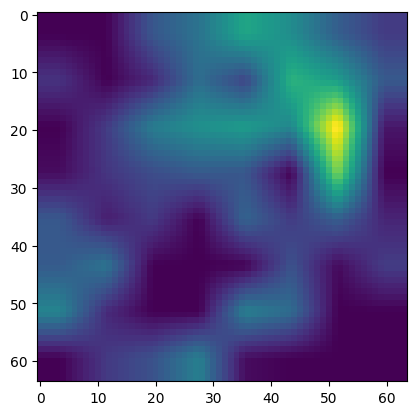

In [42]:
plt.imshow(heatmap2)